In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize']=(20,10)

In [2]:
df1=pd.read_csv('Bengaluru_House_Data.csv')
df1.head()
#we need to predict the price of real estate

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df1.shape

(13320, 9)

In [4]:
#Printing a count of each area_type category
h=df1.groupby(['area_type'])['area_type'].agg('count')
h

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [5]:
#Assume availablity, area-type, balcony and society are not important to predict price

df2=df1.drop(labels=['area_type', 'society', 'balcony', 'availability'], axis=1)
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


1. DATA CLEANING

In [6]:
#Handling NA values

df2.isnull().sum()


location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [7]:
#Since we have 30k rows, dropping 90 rows is inconsequential. Otherwise, we'd have used the median values for bath and size

df3=df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [8]:
#Handling size column. Some have 'bedrooms' while some are 'BHK's

df3['size'].unique()
df3['bhk']=df3['size'].apply(lambda x: int(x.split(' ')[0]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
df3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [10]:
#Any properties with BHKs >20 seem irrelevant considering we find there are only 2. Hence we remove them
df3[df3['bhk']>20]


,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [11]:
df3=df3[df3['bhk']<=20]
df3[df3['bhk']>20]

,location,size,total_sqft,bath,price,bhk


In [12]:
#For this we also analyse total_sqft 
df3['total_sqft'].unique()
#Here we see a dissonance in data type. So we need to resolve that

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [13]:
#First we check if a given value is float in total_sqft

def is_float(num):
  try:
    float(num)
  except:
    return False
  return True


In [14]:
#Checking values where total_sqft isn't float

df3[~df3['total_sqft'].apply(is_float)].head(10)
df3.shape

(13244, 6)

In [15]:
#Checking number of values outside a range among the values not float

def convert_sqft_to_num(x):
  token=x.split('-')
  if len(token)==2:
    return (float(token[0])+float(token[1])/2)
  try:
    return float(x)
  except:
    return None #Doesn't delete but removes the value


In [16]:
df4=df3.copy()
df4['total_sqft']=df4['total_sqft'].apply(convert_sqft_to_num)


In [17]:
df4.head()
df4.shape

(13244, 6)

2.FEATURE ENGINEERING AND DIMENSIONALITY REDUCTION

In [18]:
df5=df4.copy()
df5['price_per_sqft']=round(df5['price']*100000/df5['total_sqft'], 2)
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.81
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.38
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.56
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.89
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.00


In [19]:
df5['location'].nunique()

1303

In [20]:
location_stats=df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
#Let's put the properties with count<10 into a single category named 'Others' for dimensionality reduction

location_stats[location_stats<10].count() #These many location to be put under 'Others'


1050

In [21]:
location_other=location_stats[location_stats<10]

In [22]:
df5.location=df5.location.apply(lambda x: 'other' if x in location_other else x)

In [23]:
df5.location.nunique()
#Hence now One HOt Encoding can be applied and the Location category can be turned into Dummy Columns

254

3.OUTLIER DETECTION AND REMOVAL

In [24]:
df5.shape

(13244, 7)

In [25]:
#We use methods like assessing Std. Dev and Domain Knowledge to detct outliers. In Real Estate, for eg., the typical sqft per bhk is 300. Hence first, we can measure 
#how many rows have the same <300, and if they're insignificant, compared to dataset size, we can remove them

df5[df5.total_sqft/df5.bhk<300].shape

(742, 7)

In [26]:
#Hence we remove those values

df6=df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12502, 7)

In [27]:
#We assume the price_per_sft is normally distributed. Hence we remove any values beyond +- 3 Standard Deviations from the Mean, for every location
def remove_ppe_outliers(df):
  df_out=pd.DataFrame()
  for key, subdf in df.groupby('location'):
    mean=np.mean(subdf.price_per_sqft)
    std=np.std(subdf.price_per_sqft)
    reduced_df=subdf[(subdf.price_per_sqft<(mean+std)) & (subdf.price_per_sqft>(mean-std))]
    df_out=pd.concat([df_out, reduced_df], ignore_index=True)
  return df_out

df7=remove_ppe_outliers(df6)
df7.shape

(10216, 7)

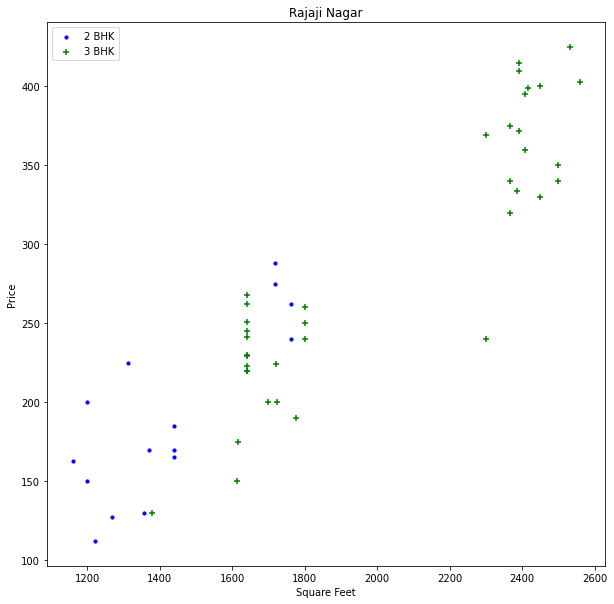

In [28]:
#We now identify such outliers where n BHK's price per sqft < mean of (n-1) BHK's price per sqft for same location.
#For that, we first visualize to see these outliers between 2 and 3BHKs for a given location

def bhk_scatter(df, location):
  bhk2 = df[(df.location==location) & (df.bhk==2)]
  bhk3 = df[(df.location==location) & (df.bhk==3)]
  plt.figure(figsize=(10,10))
  plt.scatter(bhk2['total_sqft'], bhk2['price'], color='Blue', label='2 BHK', s=10)
  plt.scatter(bhk3['total_sqft'], bhk3['price'], marker='+',color='Green', label='3 BHK')
  plt.xlabel('Square Feet')
  plt.ylabel('Price')
  plt.title(location)
  plt.legend()
  plt.show()

bhk_scatter(df7, "Rajaji Nagar")


In [29]:
df7.shape


(10216, 7)

In [30]:
#building a function to do as defined above

def remove_bhk_outliers(df):
  exclude_indices = np.array([])
  for location, location_df in df.groupby('location'):
    bhk_stats={}
    for bhk, bhk_df in location_df.groupby('bhk'):      
      bhk_stats[bhk]={
          'mean': np.mean(bhk_df.price_per_sqft),
          'std': np.std(bhk_df.price_per_sqft),
          'count': bhk_df.shape[0]
      }
    for bhk, bhk_df in location_df.groupby('bhk'):
      stats=bhk_stats.get(bhk-1) 
      if stats and stats['count']>5:
        exclude_indices=np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
  return df.drop(exclude_indices, axis='index')

df8=df7.copy()
df8=remove_bhk_outliers(df7)
df8.shape

(7376, 7)

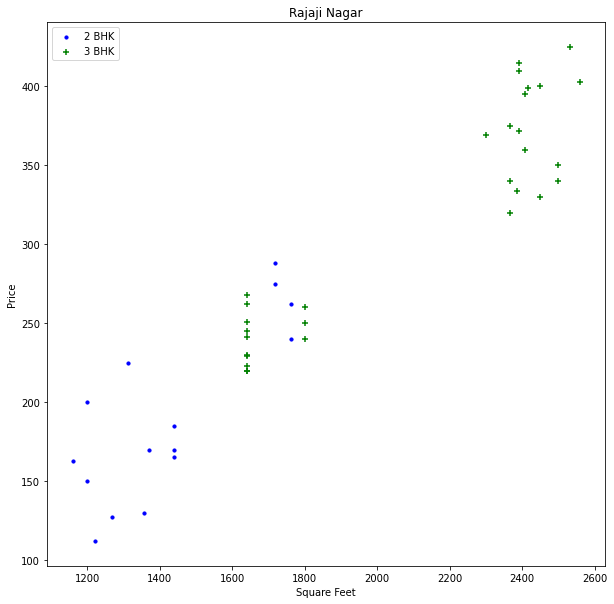

In [31]:
#checking the scatter plot of the newly handled dataframe

bhk_scatter(df8,"Rajaji Nagar")

Text(0, 0.5, 'Count of properties')

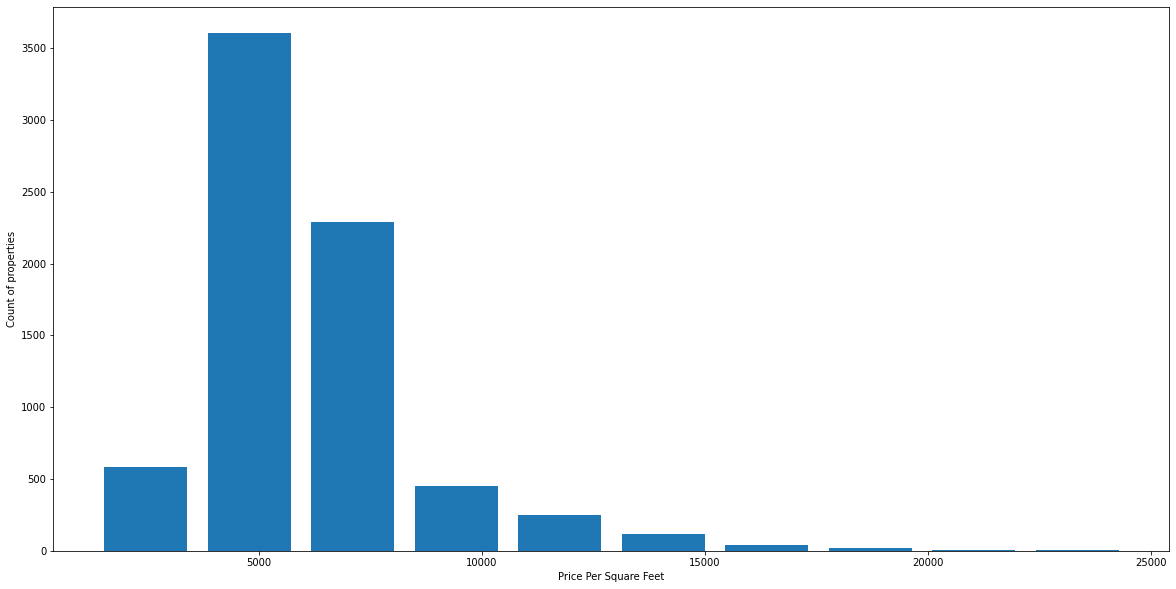

In [32]:
#PLotting histogram to see how properties are distributed through price per sq. ft.
plt.figure(figsize=(20, 10))
plt.hist(df8['price_per_sqft'], rwidth=0.8)
plt.xlabel('Price Per Square Feet')
plt.ylabel('Count of properties')

#Right-skewed 

Text(0, 0.5, 'Count of such bathrooms')

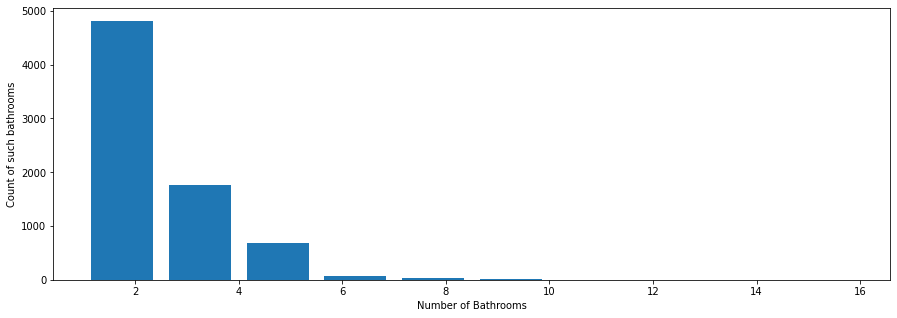

In [33]:
#Removing Outliers using Bathroom feature 
plt.figure(figsize=(15, 5))
plt.hist(df8['bath'], rwidth=0.8)
plt.xlabel('Number of Bathrooms')
plt.ylabel('Count of such bathrooms')

#We observe that the data is right-skewed

In [34]:
#We gain an insight through domain knowledge that properties don't usually have Bathrooms > BHK+2 
df9=df8[df8.bath<df8.bhk+2]

In [35]:
#Dropping unnecessary features
df10= df9.drop(labels=['size', 'price_per_sqft'], axis='columns')
df10.head()
#The dataset is now ready for ML Training

,location,total_sqft,bath,price,bhk
1,Devarachikkanahalli,1250.0,2.0,40.0,2
2,Devarachikkanahalli,1200.0,2.0,83.0,2
3,Devarachikkanahalli,1170.0,2.0,40.0,2
4,Devarachikkanahalli,1425.0,2.0,65.0,3
5,Devarachikkanahalli,947.0,2.0,43.0,2


MODEL BUILDING

In [36]:
#One HOt Encoding

dummies=pd.get_dummies(df10['location'])
dummies.head()



,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 1st Stage,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,...,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
#dropping the last column
df11=pd.concat([df10, dummies.drop('other', axis=1)], axis=1)

In [38]:
df11.head()

,location,total_sqft,bath,price,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 1st Stage,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,...,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,Devarachikkanahalli,1250.0,2.0,40.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Devarachikkanahalli,1200.0,2.0,83.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Devarachikkanahalli,1170.0,2.0,40.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Devarachikkanahalli,1425.0,2.0,65.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Devarachikkanahalli,947.0,2.0,43.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
#removing location column as it's not required anymore

df12=df11.drop(labels=['location'], axis=1)
df12.head()

,total_sqft,bath,price,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 1st Stage,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,...,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,1250.0,2.0,40.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1200.0,2.0,83.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1170.0,2.0,40.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1425.0,2.0,65.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,947.0,2.0,43.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
df12.shape

(7302, 257)

In [41]:
#Variable X contains only the independent variables
X=df12.drop(['price'], axis=1)
X.head(3)

,total_sqft,bath,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 1st Stage,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,...,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,1250.0,2.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1200.0,2.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1170.0,2.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
#Variable Y contains the dependent variable Price
y=df12.price
y.head(2)

1    40.0
2    83.0
Name: price, dtype: float64

In [43]:
#Train-Test Split Method

#To train model, we use Train dataset
#To evaluate model performance, we use Test Dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=10) #Data divided into Train:Test ratio of 8:2


In [44]:
#Linear-Regression Model
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train) #Model trains in this step
lr_clf.score(X_test, y_test) #Gives the score fo how the model performed


0.8482763718215447

In [45]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)#Shuffle Split will randomize the sample, so each fold has equal distribution of data sample

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.77350327, 0.85431388, 0.84131364, 0.82240173, 0.90015474])

In [46]:
#There exist other regression techniques such as Lasso Regression and Decision-tree Regression. For this we use a method called Grid Search CV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #5-fold validation
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)


,model,best_score,best_params
0,linear_regression,0.838337,{'normalize': True}
1,lasso,0.699824,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.686373,"{'criterion': 'mse', 'splitter': 'random'}"


In [47]:
#Price prediction function

def predict_price(location,sqft,bath,bhk):    
  loc_index = np.where(X.columns==location)[0][0]

  x = np.zeros(len(X.columns))
  x[0] = sqft
  x[1] = bath
  x[2] = bhk
  if loc_index >= 0:
      x[loc_index] = 1

  return lr_clf.predict([x])[0]

In [48]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

82.10925801207496

In [49]:
predict_price('1st Phase JP Nagar',1000, 2, 3)

82.72611169376744

In [50]:
predict_price('Indira Nagar',1000, 2, 3)

177.49426374753773

In [51]:
#Exporting the model to a pickle file to be used by Python Flask server 
#A/B testing used here as well by Data Scientists to test old vs new models


import pickle
with open('bengaluru_price_model.pickle', 'wb') as f:
  pickle.dump(lr_clf, f)

In [53]:
#we also need the columns info (the way they're structured and indexed into the list)
import json
columns={
    'data_columns': [col.lower() for col in X.columns]
}
with open('columns.json', 'w') as f:
  f.write(json.dumps(columns))

#We need the json file and the pickle model for the python flask server as artifacts